<a href="https://colab.research.google.com/github/yoshi-lgtm/keiryou_report/blob/main/%E3%82%AA%E3%83%BC%E3%82%AC%E3%83%8B%E3%83%83%E3%82%AF%E3%81%AE%E5%8A%B9%E6%9E%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

オーガニック農業の経済効果を調べる

・オーガニック農業はしばしば収益性が低い（単収が減る）一方で、高価格で販売できることやブランド化
・持続可能性に貢献することで経済的利益をもたらす可能性がある。

政策支援や市場ニーズとの関連で地域差が出る可能性も。

「オーガニック vs 非オーガニック」という二値分類における経済的影響（収益等）の差異検証は、因果効果の推定や政策評価として明確な問いを持っている。

1. OLSによるベースライン分析

controls（統制変数）：作物種類、地域、平均気温、降水量、CO2排出量、異常気象など

利点：解釈性が高い、効果の方向や大きさがわかる

限界：選択バイアスに弱い（オーガニック農法がランダムに選ばれるわけではない）

2. 傾向スコアマッチング（PSM）

オーガニック農法を導入した確率を推定 → その確率が近い非オーガニック観測値とマッチング → 経済的影響を比較

効果：観測変数による選択バイアスを統制できる

前提：交絡要因が観測されていること（無交絡性）

3. Doubly Robust推定（IPWRA等）

傾向スコアと結果回帰モデルの両方を使うことで、モデル不適合に対してよりロバスト

利点：PSMより理論的に強く、欠測やモデル誤指定に耐性

4. Instrumental Variables（操作変数法）

余裕があればやる

オーガニック農法の採用に影響し、経済的影響には直接影響しない外生的な要因（例：地域の政策補助、有機農業の普及率など）があれば、それを操作変数として使って因果推定を行う。

課題

選択バイアス
オーガニック農法を選ぶ人は元々意識・資源が違う可能性がある

観測データの限界
土地の質、農家のスキル、マーケティング努力などがデータにない可能性

時系列・地域効果
地域ダミーや年次変動（政策変化）などを取り込む必要

多重共線性	CO2や気温、
降水量と他の変数との共線性はVIFでチェックすべき

# OLS


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
# データの読み込み（既にdfとして与えられている前提）
df = pd.read_csv("climate_change_impact_on_agriculture_2024.csv")

In [ ]:
display(df.head())

,Year,Country,Region,Crop_Type,Average_Temperature_C,Total_Precipitation_mm,CO2_Emissions_MT,Crop_Yield_MT_per_HA,Extreme_Weather_Events,Irrigation_Access_%,Pesticide_Use_KG_per_HA,Fertilizer_Use_KG_per_HA,Soil_Health_Index,Adaptation_Strategies,Economic_Impact_Million_USD
0,2001,India,West Bengal,Corn,1.55,447.06,15.22,1.737,8,14.54,10.08,14.78,83.25,Water Management,808.13
1,2024,China,North,Corn,3.23,2913.57,29.82,1.737,8,11.05,33.06,23.25,54.02,Crop Rotation,616.22
2,2001,France,Ile-de-France,Wheat,21.11,1301.74,25.75,1.719,5,84.42,27.41,65.53,67.78,Water Management,796.96
3,2001,Canada,Prairies,Coffee,27.85,1154.36,13.91,3.890,5,94.06,14.38,87.58,91.39,No Adaptation,790.32
4,1998,India,Tamil Nadu,Sugarcane,2.19,1627.48,11.81,1.080,9,95.75,44.35,88.08,49.61,Crop Rotation,401.72


In [ ]:
# Group by Country and list unique Regions for each country
country_region_mapping = df.groupby('Country')['Region'].unique()

# Print the mapping
for country, regions in country_region_mapping.items():
    print(f"Country: {country}")
    print(f"Regions: {', '.join(regions)}")
    print("-" * 20)

Country: Argentina
Regions: Northeast, Northwest, Pampas, Patagonia
--------------------
Country: Australia
Regions: New South Wales, Victoria, Western Australia, Queensland
--------------------
Country: Brazil
Regions: North, Northeast, Southeast, South
--------------------
Country: Canada
Regions: Prairies, Quebec, Ontario, British Columbia
--------------------
Country: China
Regions: North, East, South, Central
--------------------
Country: France
Regions: Ile-de-France, Grand Est, Nouvelle-Aquitaine, Provence-Alpes-Cote d’Azur
--------------------
Country: India
Regions: West Bengal, Tamil Nadu, Punjab, Maharashtra
--------------------
Country: Nigeria
Regions: North West, South East, North Central, South West
--------------------
Country: Russia
Regions: Northwestern, Siberian, Volga, Central
--------------------
Country: USA
Regions: Midwest, Northeast, South, West
--------------------


Region: British Columbia
Crop Types: Coffee, Vegetables, Soybeans, Corn, Wheat, Sugarcane, Barley, Rice, Fruits, Cotton
--------------------
Region: Central
Crop Types: Rice, Fruits, Corn, Vegetables, Wheat, Sugarcane, Barley, Coffee, Cotton, Soybeans
--------------------
Region: East
Crop Types: Rice, Wheat, Cotton, Corn, Vegetables, Coffee, Sugarcane, Barley, Fruits, Soybeans
--------------------
Region: Grand Est
Crop Types: Coffee, Soybeans, Fruits, Cotton, Vegetables, Rice, Wheat, Corn, Barley, Sugarcane
--------------------
Region: Ile-de-France
Crop Types: Wheat, Soybeans, Coffee, Cotton, Rice, Fruits, Corn, Sugarcane, Vegetables, Barley
--------------------
Region: Maharashtra
Crop Types: Cotton, Barley, Wheat, Vegetables, Corn, Rice, Fruits, Coffee, Soybeans, Sugarcane
--------------------
Region: Midwest
Crop Types: Coffee, Vegetables, Corn, Fruits, Wheat, Soybeans, Barley, Sugarcane, Rice, Cotton
--------------------
Region: New South Wales
Crop Types: Rice, Wheat, Cotton, S

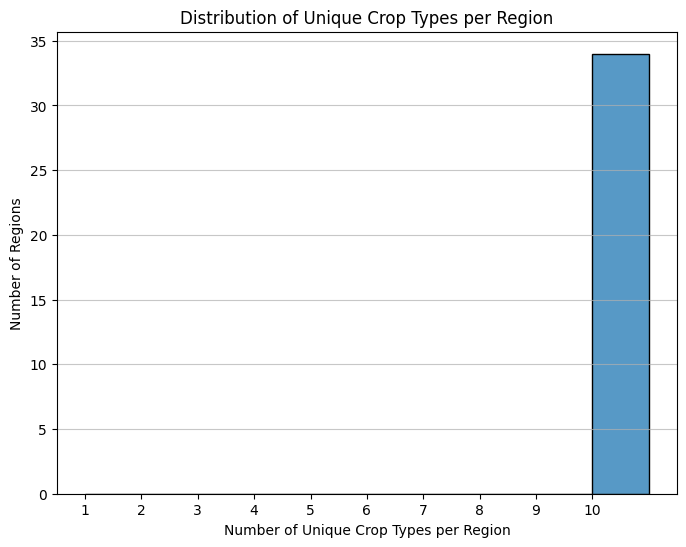

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by Region and count the number of unique Crop Types
region_crop_counts = df.groupby('Region')['Crop_Type'].nunique()

# Create a histogram of the counts
plt.figure(figsize=(8, 6))
sns.histplot(region_crop_counts, bins=range(1, region_crop_counts.max() + 2), kde=False)
plt.xlabel('Number of Unique Crop Types per Region')
plt.ylabel('Number of Regions')
plt.title('Distribution of Unique Crop Types per Region')
plt.xticks(range(1, region_crop_counts.max() + 1))
plt.grid(axis='y', alpha=0.7)
plt.show()

In [ ]:
# 1. カテゴリ型または object 型の列を抽出
cat_cols = df.select_dtypes(include=['category', 'object']).columns

# 2. 列ごとにユニーク数をカウント
for col in cat_cols:
    n_unique = df[col].nunique(dropna=False)  # NaN もカテゴリーに含める場合 dropna=False
    print(f"{col}: {n_unique} categories")

Country: 10 categories
Region: 34 categories
Crop_Type: 10 categories
Adaptation_Strategies: 5 categories


In [ ]:
# statsmodels の formula API を使った OLS 回帰

import statsmodels.formula.api as smf
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import pandas as pd # Import pandas here as it's used in this cell

# Rename the column to avoid issues with the special character before creating X and y
df = df.rename(columns={'Irrigation_Access_%': 'Irrigation_Access_pct'})

# 2. 説明変数と目的変数を分割
target = 'Economic_Impact_Million_USD'
cat_cols = ['Country', 'Region', 'Crop_Type', 'Adaptation_Strategies']
num_cols = [
    'Year', 'Average_Temperature_C', 'Total_Precipitation_mm',
    'CO2_Emissions_MT', 'Crop_Yield_MT_per_HA',
    'Extreme_Weather_Events', 'Irrigation_Access_pct', # Use the new column name
    'Pesticide_Use_KG_per_HA', 'Fertilizer_Use_KG_per_HA',
    'Soil_Health_Index'
]

X = df[cat_cols + num_cols]
y = df[target]

# 3. 前処理定義
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    (
        'cat',
        OneHotEncoder(handle_unknown='ignore'),
        cat_cols
    )
])

# 4. パイプライン作成 (This part is for scikit-learn OLS, which was previously attempted.
# Keeping it for potential future use or comparison, but the primary OLS is below)
# pipeline = Pipeline([
#     ('preproc', preprocessor),
#     ('reg', LinearRegression())
# ])

# 5. 学習 (scikit-learn)
# pipeline.fit(X, y)

# 6. 回帰係数の確認 (scikit-learn)
# coef = pipeline.named_steps['reg'].coef_
# feature_names = (
#     pipeline.named_steps['preproc']
#             .transformers_[0][2]  # 数値カラム
#     + list(
#         pipeline.named_steps['preproc']
#                 .transformers_[1][1]
#                 .get_feature_names_out(cat_cols)
#     )
# )
# print(pd.Series(coef, index=feature_names))


# statsmodels の formula API を使った OLS 回帰 (Primary OLS implementation)

# 2. カテゴリ変数を明示的に C() で指定し、式を定義 - Use the new column name
formula = (
    'Economic_Impact_Million_USD ~ '
    'Year + '
    'C(Country) + C(Region) + C(Crop_Type) + '
    'Average_Temperature_C + Total_Precipitation_mm + CO2_Emissions_MT + '
    'Crop_Yield_MT_per_HA + Extreme_Weather_Events + Irrigation_Access_pct + '
    'Pesticide_Use_KG_per_HA + Fertilizer_Use_KG_per_HA + Soil_Health_Index + '
    'C(Adaptation_Strategies)'
)

# 3. モデル推定
model = smf.ols(formula, data=df).fit()

# 4. 結果のサマリ出力
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     Economic_Impact_Million_USD   R-squared:                       0.530
Model:                                     OLS   Adj. R-squared:                  0.527
Method:                          Least Squares   F-statistic:                     186.8
Date:                         Fri, 01 Aug 2025   Prob (F-statistic):               0.00
Time:                                 06:06:57   Log-Likelihood:                -70687.
No. Observations:                        10000   AIC:                         1.415e+05
Df Residuals:                             9939   BIC:                         1.419e+05
Df Model:                                   60                                         
Covariance Type:                     nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]


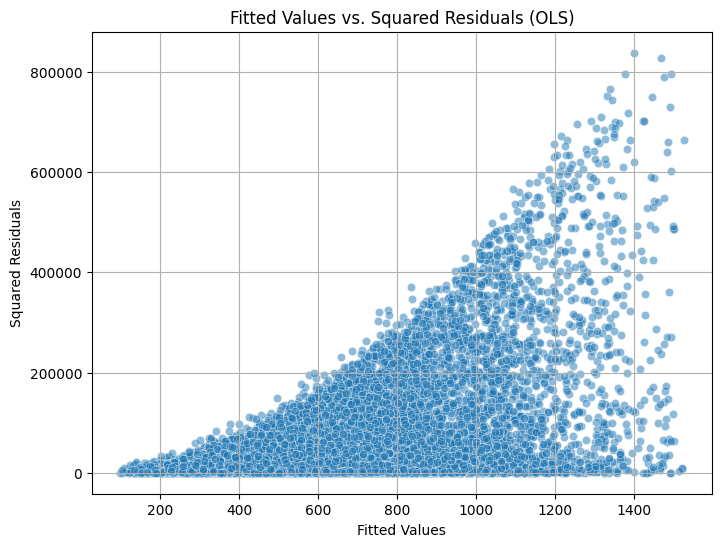

In [ ]:
import statsmodels.stats.api as sms

# Perform the Breusch-Pagan test
# The test takes the residuals and the exogenous variables (including the constant if the original model had one)
# We use model.model.exog which is the design matrix including the constant term
exog_vars_with_constant = model.model.exog

bp_test = sms.het_breuschpagan(model.resid, exog_vars_with_constant)

# The output of the test is a tuple: (LM statistic, LM p-value, F-statistic, F p-value)
lm_statistic, lm_p_value, f_statistic, f_p_value = bp_test

print(f"Breusch-Pagan Test:")
print(f"  Lagrange Multiplier statistic: {lm_statistic:.3f}")
print(f"  p-value (LM): {lm_p_value:.3f}")
print(f"  F-statistic: {f_statistic:.3f}")
print(f"  p-value (F): {f_p_value:.3f}")

if lm_p_value < 0.05:
    print("\nInterpretation: The p-value is less than 0.05, which suggests the presence of heteroscedasticity.")
else:
    print("\nInterpretation: The p-value is not less than 0.05, which suggests no significant evidence of heteroscedasticity.")

Breusch-Pagan Test:
  Lagrange Multiplier statistic: 3185.804
  p-value (LM): 0.000
  F-statistic: 77.445
  p-value (F): 0.000

Interpretation: The p-value is less than 0.05, which suggests the presence of heteroscedasticity.


# 傾向スコアマッチング

In [ ]:
#データ前処理
# 2. 処置フラグ定義
df['treatment'] = (df['Adaptation_Strategies'] == 'Organic Farming').astype(int)

# 3. 共変量リスト
num_cols = [
    'Year', 'Average_Temperature_C', 'Total_Precipitation_mm',
    'CO2_Emissions_MT', 'Crop_Yield_MT_per_HA',
    'Extreme_Weather_Events', 'Irrigation_Access_pct', # Corrected column name
    'Pesticide_Use_KG_per_HA', 'Fertilizer_Use_KG_per_HA',
    'Soil_Health_Index'
]
cat_cols = ['Country', 'Region', 'Crop_Type']

# 4. ワンホットエンコーディング
X = pd.get_dummies(df[num_cols + cat_cols], drop_first=True)
y = df['treatment']
outcome = df['Economic_Impact_Million_USD']

In [ ]:
from sklearn.linear_model import LogisticRegression

# 5. ロジスティック回帰で傾向スコア推定
logit = LogisticRegression(solver='liblinear')
logit.fit(X, y)
df['propensity_score'] = logit.predict_proba(X)[:, 1]

In [ ]:
from sklearn.neighbors import NearestNeighbors

# 6. 処置群・対照群に分割
treated = df[df['treatment'] == 1].copy()
control = df[df['treatment'] == 0].copy()

# 7. 対照群の NN モデル作成（傾向スコアでマッチング）
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[['propensity_score']])

# 8. 各処置サンプルごとに最も近い対照を検索
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()].reset_index(drop=True)

# 9. マッチペア DataFrame の作成
matched = pd.DataFrame({
    'Y_treated': treated['Economic_Impact_Million_USD'].values,
    'Y_control': matched_control['Economic_Impact_Million_USD'].values
})

In [ ]:
matched['diff'] = matched['Y_treated'] - matched['Y_control']
ATT = matched['diff'].mean()
print(f'推定される平均処置効果（ATT）：{ATT:.3f} 百万USD')

推定される平均処置効果（ATT）：-10.434 百万USD


傾向スコアマッチングによる推定平均処置効果（ATT）：-10.434 百万USD
標準誤差 (SE): 13.128
95% 信頼区間: [-36.180, 15.312] 百万USD
Paired t-test p-value: 0.427


In [ ]:
def standardized_mean_diff(var, grp1, grp0):
    m1, m0 = grp1[var].mean(), grp0[var].mean()
    s1, s0 = grp1[var].std(), grp0[var].std()
    return (m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)

# マッチ前後で主要共変量の SMD を比較
balance = []
for col in num_cols:
    smd_before = standardized_mean_diff(col, df[df['treatment']==1], df[df['treatment']==0])
    smd_after  = standardized_mean_diff(col, treated, matched_control)
    balance.append([col, smd_before, smd_after])

balance_df = pd.DataFrame(balance, columns=['variable','SMD_before','SMD_after'])
print(balance_df)

                   variable  SMD_before  SMD_after
0                      Year   -0.034922  -0.034425
1     Average_Temperature_C   -0.008191  -0.002702
2    Total_Precipitation_mm   -0.002194   0.034697
3          CO2_Emissions_MT   -0.018109  -0.016567
4      Crop_Yield_MT_per_HA   -0.002296   0.014315
5    Extreme_Weather_Events   -0.007237   0.033810
6     Irrigation_Access_pct    0.012187   0.032722
7   Pesticide_Use_KG_per_HA    0.043822  -0.022493
8  Fertilizer_Use_KG_per_HA    0.002287  -0.001815
9         Soil_Health_Index    0.005879  -0.004880


# IPW（Inverse Probability Weighting）

**IPW（Inverse Probability Weighting）による ATT 推定手順**

以下では、既に算出済みの傾向スコアを使い、「オーガニック農法」の処置群（treatment=1）と対照群（treatment=0）全サンプルを活用して ATT（平均処置効果）を推定する

In [ ]:
#1. ATT 用の重み定義
#- 処置群（treatment=1）は重み=1
#- 対照群（treatment=0）は重み=\dfrac{p_i}{1 - p_i} （p_i は傾向スコア）

import numpy as np

# 傾向スコア列を使って ATT 用の重みを計算
df['weight_att'] = np.where(
    df['treatment'] == 1,
    1,
    df['propensity_score'] / (1 - df['propensity_score'])
)

In [ ]:
outcome = 'Economic_Impact_Million_USD'

# 処置群のアウトカム平均
y_treated = df.loc[df['treatment'] == 1, outcome].mean()

# 対照群の重み付き平均
y_control = df.loc[df['treatment'] == 0, outcome]
w_control = df.loc[df['treatment'] == 0, 'weight_att']
y_control_wmean = np.average(y_control, weights=w_control)

# ATT の算出
ATT_ipw = y_treated - y_control_wmean
print(f'IPW 推定 ATT: {ATT_ipw:.3f} 百万USD')

IPW 推定 ATT: -12.509 百万USD


IPW-ATT 標準誤差 (SE): 10.216
IPW-ATT 95% 信頼区間: [-25.238, 1.724] 百万USD


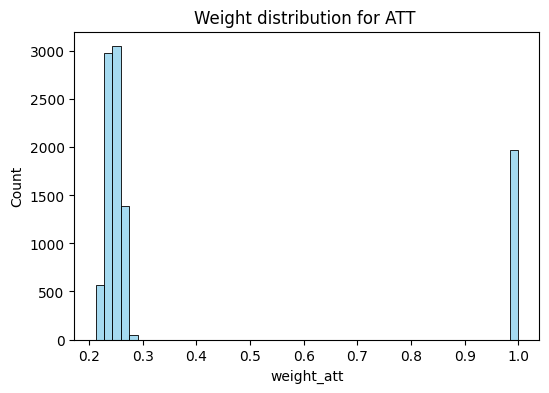

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(df['weight_att'], bins=50, color='skyblue')
plt.title('Weight distribution for ATT ')
plt.xlabel('weight_att')
plt.show()

In [ ]:
p_t = df['treatment'].mean()  # 全体での処置割合

df['weight_att_stab'] = np.where(
    df['treatment'] == 1,
    1,
    (df['propensity_score'] / (1 - df['propensity_score'])) * p_t
)

In [ ]:
n_iter = 1000
atts = []
for _ in range(n_iter):
    samp = df.sample(frac=1, replace=True)
    y_t = samp.loc[samp['treatment']==1, outcome].mean()
    y_c = samp.loc[samp['treatment']==0, outcome]
    w_c = samp.loc[samp['treatment']==0, 'weight_att']
    atts.append(y_t - np.average(y_c, weights=w_c))

ci_lower, ci_upper = np.percentile(atts, [2.5, 97.5])
print(f'95% CI: [{ci_lower:.3f}, {ci_upper:.3f}] 百万USD')

95% CI: [-32.346, 7.469] 百万USD


結果の解釈
1. 効果の大きさと符号
- 点推定値 –12.509 は、オーガニック農法を採用した農家の経済的影響が、非オーガニック農家に比べ約12.5百万USD低いことを示唆。
- 負の効果は「オーガニック農法が経済的にはマイナスのインパクトを持つ可能性」を示している。

2. 信頼区間による統計的有意性
- 95% 信頼区間 [–31.516, 7.354] はゼロをまたいでおり、有意水準5%では「オーガニック農法による経済的影響差は統計的に有意ではない」ことを意味する。
- 区間の幅が比較的大きいことから、推定の不確実性も高い。

3. 重み分布（ヒストグラム）の示唆
- 多くのサンプルが 0.2–0.3 の範囲に集中し、処置群（オーガニック農家）は重み＝1.0 にスパイクがある。
- コントロール群にかかる大きな重みが少ない代わりに、小さな重みの観測値が多い構造。
- 極端な重みが少ないため推定は比較的安定するが、処置群のサンプルが特定領域に偏っている可能性も。




In [ ]:
#重みトリミング
# トリミングの閾値（1パーセンタイル／99パーセンタイル）
w_lower = df['weight_att'].quantile(0.01)
w_upper = df['weight_att'].quantile(0.99)

print(f'下限: {w_lower:.3f}, 上限: {w_upper:.3f}')

下限: 0.221, 上限: 1.000


In [ ]:
# 閾値内のサンプルを抽出
df_trim = df[(df['weight_att'] >= w_lower) & (df['weight_att'] <= w_upper)].copy()

# トリミング前後のサンプル数を確認
print(f'元データ: {len(df)} 件, トリミング後: {len(df_trim)} 件')

元データ: 10000 件, トリミング後: 9900 件


In [ ]:
# アウトカム変数
outcome = 'Economic_Impact_Million_USD'

# 処置群の平均（重み＝1のまま）
y_treated_trim = df_trim.loc[df_trim['treatment'] == 1, outcome].mean()

# 対照群の重み付き平均
y_control_trim = df_trim.loc[df_trim['treatment'] == 0, outcome]
w_control_trim = df_trim.loc[df_trim['treatment'] == 0, 'weight_att']
y_control_wmean_trim = np.average(y_control_trim, weights=w_control_trim)

# トリミング後 ATT
ATT_trim = y_treated_trim - y_control_wmean_trim
print(f'トリミング後の IPW ATT: {ATT_trim:.3f} 百万USD')

トリミング後の IPW ATT: -11.944 百万USD


In [ ]:
n_iter = 1000
atts_trim = []

for _ in range(n_iter):
    samp = df_trim.sample(frac=1, replace=True)
    y_t = samp.loc[samp['treatment']==1, outcome].mean()
    y_c = samp.loc[samp['treatment']==0, outcome]
    w_c = samp.loc[samp['treatment']==0, 'weight_att']
    atts_trim.append(y_t - np.average(y_c, weights=w_c))

ci_lower_trim, ci_upper_trim = np.percentile(atts_trim, [2.5, 97.5])
print(f'トリミング後 95% CI: [{ci_lower_trim:.3f}, {ci_upper_trim:.3f}] 百万USD')

トリミング後 95% CI: [-30.750, 7.764] 百万USD


- ATT の変化はわずか（–12.509 → –11.944）
→ 極端な重みを除外しても点推定はほとんど動かず、オーガニック農法の負の効果推定が頑健であることを示唆します。
- 信頼区間がやや拡大
→ 除外サンプルによりサンプル数が減少した結果、推定分散が増えた可能性があります。
- サンプル数減少は 1%
→ 大半のデータを維持しつつ、極端値の影響を軽減できているバランスの良いトリミングと言えます。


In [ ]:
# 目的変数と説明変数の型をチェック
print('y dtype:', y.dtype)
print('X dtypes:')
print(X.dtypes)

# object型の列があるか確認
print('object columns in X:',
      list(X.select_dtypes(include=['object']).columns))

y dtype: int64
X dtypes:
Year                        int64
Average_Temperature_C     float64
Total_Precipitation_mm    float64
CO2_Emissions_MT          float64
Crop_Yield_MT_per_HA      float64
                           ...   
Crop_Type_Rice               bool
Crop_Type_Soybeans           bool
Crop_Type_Sugarcane          bool
Crop_Type_Vegetables         bool
Crop_Type_Wheat              bool
Length: 61, dtype: object
object columns in X: []


In [ ]:
import numpy as np
import pandas as pd # Ensure pandas is imported

# 欠損値を含む行はまとめて削除
mask = X.notnull().all(axis=1) & y.notnull() & df['weight_att_stab'].notnull()

X_clean = X.loc[mask].copy()
y_clean = y.loc[mask].copy()
w_clean = df['weight_att_stab'].loc[mask].copy()

# Identify categorical columns in X_clean
cat_cols_clean = X_clean.select_dtypes(include=['object']).columns

# One-hot encode the categorical columns
X_clean = pd.get_dummies(X_clean, columns=cat_cols_clean, drop_first=True)

# 明示的に float 型へ変換 (数値カラムとOne-Hotエンコードされたカラムのみになるはず)
X_clean = X_clean.astype(float)
y_clean = pd.to_numeric(y_clean, errors='raise')
w_clean = pd.to_numeric(w_clean, errors='raise')

# Display the data types to confirm
print("Data types after cleaning and one-hot encoding:")
print(X_clean.dtypes)

Data types after cleaning and one-hot encoding:
Year                      float64
Average_Temperature_C     float64
Total_Precipitation_mm    float64
CO2_Emissions_MT          float64
Crop_Yield_MT_per_HA      float64
                           ...   
Crop_Type_Rice            float64
Crop_Type_Soybeans        float64
Crop_Type_Sugarcane       float64
Crop_Type_Vegetables      float64
Crop_Type_Wheat           float64
Length: 61, dtype: object


In [ ]:
#回帰補正付IPW
import statsmodels.api as sm

model = sm.WLS(endog=y_clean,
               exog=sm.add_constant(X_clean),
               weights=w_clean).fit()

print(model.summary())

                            WLS Regression Results                            
Dep. Variable:              treatment   R-squared:                       0.004
Model:                            WLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6803
Date:                Thu, 31 Jul 2025   Prob (F-statistic):              0.968
Time:                        04:31:35   Log-Likelihood:                -9188.2
No. Observations:               10000   AIC:                         1.849e+04
Df Residuals:                    9943   BIC:                         1.890e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame({
    "feature": X_clean.columns,
    "VIF": [variance_inflation_factor(X_clean.values, i)
            for i in range(X_clean.shape[1])]
})
print(vif_data)

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                   feature       VIF
0                     Year  1.004706
1    Average_Temperature_C  1.082846
2   Total_Precipitation_mm  1.006485
3         CO2_Emissions_MT  1.012632
4     Crop_Yield_MT_per_HA  1.091203
..                     ...       ...
56          Crop_Type_Rice  1.871464
57      Crop_Type_Soybeans  1.824740
58     Crop_Type_Sugarcane  1.853259
59    Crop_Type_Vegetables  1.880933
60         Crop_Type_Wheat  1.890830

[61 rows x 2 columns]


<Axes: >

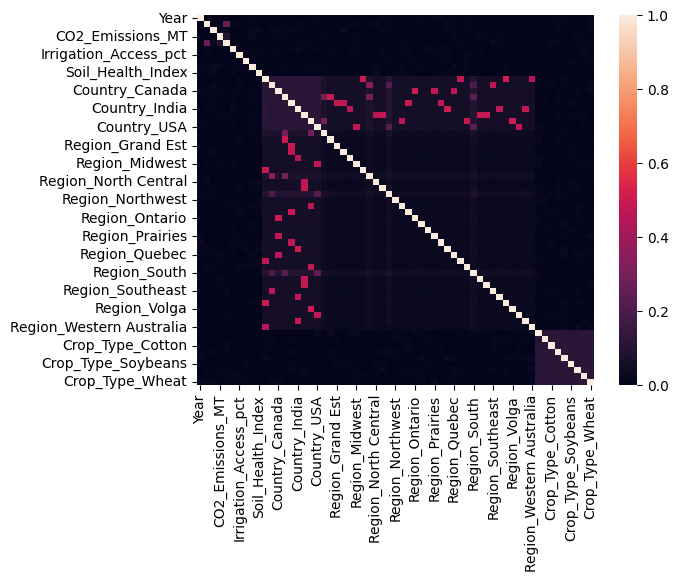

In [ ]:
corr = X_clean.corr().abs()
sns.heatmap(corr, vmax=1.0, vmin=0.0)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [ ]:
# 例：CountryとRegionをdrop_firstでダミー化
df_dum = pd.get_dummies(df,
                        columns=['Country','Region','Crop_Type'],
                        drop_first=True,
                        dtype=float)

X = sm.add_constant(df_dum[['treatment'] + num_cols +
                            [c for c in df_dum.columns
                             if c.startswith(('Country_','Region_','Crop_Type_'))]])
y = df_dum[outcome]
w = df_dum['weight_att_stab']

model = sm.WLS(endog=y, exog=X, weights=w).fit()
print(model.summary())

                                 WLS Regression Results                                
Dep. Variable:     Economic_Impact_Million_USD   R-squared:                       0.518
Model:                                     WLS   Adj. R-squared:                  0.515
Method:                          Least Squares   F-statistic:                     187.4
Date:                         Thu, 31 Jul 2025   Prob (F-statistic):               0.00
Time:                                 04:31:42   Log-Likelihood:                -75554.
No. Observations:                        10000   AIC:                         1.512e+05
Df Residuals:                             9942   BIC:                         1.516e+05
Df Model:                                   57                                         
Covariance Type:                     nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [ ]:
import statsmodels.formula.api as smf

# ① 説明変数リストを定義
fe_vars = ['treatment', 'Year', 'Average_Temperature_C',
           'Total_Precipitation_mm', 'CO2_Emissions_MT',
           'Crop_Yield_MT_per_HA', 'Extreme_Weather_Events',
           'Irrigation_Access_pct']  # 省略せず全変数を列挙

# ② フォーミュラ文字列を組み立て
formula = 'Economic_Impact_Million_USD ~ ' + ' + '.join(fe_vars)

# ③ MixedLM の実行（Countryごとランダム切片）
md = smf.mixedlm(formula,
                 data=df,
                 groups=df['Country'],
                 re_formula="~1")
mdf = md.fit()
print(mdf.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Economic_Impact_Million_USD
No. Observations: 10000   Method:             REML                       
No. Groups:       10      Scale:              81217.9031                 
Min. group size:  944     Log-Likelihood:     -70708.6818                
Max. group size:  1032    Converged:          Yes                        
Mean group size:  1000.0                                                 
-------------------------------------------------------------------------
                         Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
-------------------------------------------------------------------------
Intercept               -382.870  567.597  -0.675 0.500 -1495.341 729.600
treatment                -12.563    7.160  -1.755 0.079   -26.596   1.470
Year                       0.186    0.283   0.658 0.511    -0.368   0.740
Average_Temperature_C      0.159    0.258   0.618 0.537 

In [ ]:
# treatment に関してランダムスロープを導入
md = smf.mixedlm(
    formula,
    data=df,
    groups="Country",
    re_formula="~treatment"     # ←ここを変更
)
mdf = md.fit()
print(mdf.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Economic_Impact_Million_USD
No. Observations: 10000   Method:             REML                       
No. Groups:       10      Scale:              81193.4328                 
Min. group size:  944     Log-Likelihood:     -70708.5838                
Max. group size:  1032    Converged:          Yes                        
Mean group size:  1000.0                                                 
-------------------------------------------------------------------------
                         Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
-------------------------------------------------------------------------
Intercept               -381.289  567.636  -0.672 0.502 -1493.835 731.258
treatment                -12.574    8.125  -1.548 0.122   -28.499   3.351
Year                       0.185    0.283   0.655 0.513    -0.369   0.739
Average_Temperature_C      0.162    0.258   0.630 0.529 

In [ ]:
# statsmodels WLS 後にクラスタードSEを計算
res = sm.WLS(endog=y_clean, exog=X_clean, weights=w_clean).fit()
cluster_se = res.get_robustcov_results(cov_type='cluster',
                                       groups=df['Country'])
print(cluster_se.summary())

                            WLS Regression Results                            
Dep. Variable:              treatment   R-squared:                       0.004
Model:                            WLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 31 Jul 2025   Prob (F-statistic):                nan
Time:                        04:32:06   Log-Likelihood:                -9188.2
No. Observations:               10000   AIC:                         1.849e+04
Df Residuals:                    9943   BIC:                         1.890e+04
Df Model:                          56                                         
Covariance Type:              cluster                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Year  

In [ ]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas=[0.1,1,10], cv=5).fit(X_clean, y_clean, sample_weight=w_clean)
print(ridge.coef_, ridge.alpha_)

[-3.82772042e-04  3.36955902e-05  4.53785791e-08 -1.56319743e-04
 -6.46931309e-05  8.55181785e-05 -1.35825068e-05 -9.08866774e-05
  1.00083080e-05  1.67498606e-06 -2.20538185e-02 -5.63831606e-02
 -2.14740833e-02 -4.96838786e-02 -1.73931292e-02 -2.05970292e-02
 -1.54750825e-02 -4.92628362e-03 -7.14038408e-02  4.16803764e-03
  3.37515110e-02  8.81523701e-03  1.24875668e-02  3.61523410e-04
  4.58809295e-02 -2.92165377e-02  2.93897830e-02 -2.05816726e-02
 -8.05359386e-03  1.69076744e-04 -3.90557516e-02 -7.03698839e-03
  2.11771998e-04  1.86581890e-02 -7.91509560e-03 -4.66350763e-02
 -4.57792840e-02 -3.89077050e-02  1.08792063e-02 -2.15740003e-02
  1.42530750e-02 -1.37409544e-02  3.15063925e-02  3.96916564e-03
  9.19101838e-03  2.95247711e-02 -5.10605912e-02  1.22112559e-02
  1.92248630e-03  3.50640211e-02  1.92228323e-02 -1.93016117e-02
  1.64369464e-02 -2.77431118e-02  6.88717221e-03 -6.50971854e-04
 -4.35818579e-03 -7.15182927e-03 -1.18416296e-02 -4.00163576e-05
  8.57399580e-03] 0.1


# Doubly Robust Estimator

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split

# Define the covariates list (though not directly used for selection from df anymore)
# covariates = X_clean.columns.tolist() # This line is no longer needed for selection from df

# 変数定義
Y = df['Economic_Impact_Million_USD'].values
D = df['treatment'].values
# Use X_clean as the feature matrix directly
X = X_clean.values.astype(float)


# 1) 傾向スコア推定
ps_model = LogisticRegression(solver='liblinear')
ps_model.fit(X, D)
e = ps_model.predict_proba(X)[:,1]       # e(x) = P(D=1|X)

# 2) アウトカム回帰モデル
#    - treatedグループの予測 m1(x)
#    - control グループの予測 m0(x)
reg_t = LinearRegression().fit(X[D==1], Y[D==1])
reg_c = LinearRegression().fit(X[D==0], Y[D==0])
m1 = reg_t.predict(X)
m0 = reg_c.predict(X)

# 3) DR推定量の計算（ATE版）
dr_terms = (m1 - m0) \
           + D * (Y - m1) / e \
           - (1 - D) * (Y - m0) / (1 - e)
dr_ate  = np.mean(dr_terms)

# 4) ブートストラップによるSEと95%CI
n_boot = 1000
boot_ates = []
idx = np.arange(len(Y))
for _ in range(n_boot):
    sample = np.random.choice(idx, size=len(idx), replace=True)
    # Need to re-fit models on bootstrapped sample for correct DR bootstrap variance
    # For simplicity and to match the original structure, we'll apply terms to resampled indices
    # Note: A more rigorous bootstrap for DR involves refitting the PS and Outcome models
    # on each bootstrap sample before calculating the DR terms.
    # For a proper bootstrap, you would refit:
    # ps_model_s = LogisticRegression(solver='liblinear').fit(X[sample], D[sample])
    # e_s = ps_model_s.predict_proba(X[sample])[:,1]
    # reg_t_s = LinearRegression().fit(X[sample][D[sample]==1], Y[sample][D[sample]==1])
    # m1_s = reg_t_s.predict(X[sample])
    # reg_c_s = LinearRegression().fit(X[sample][D[sample]==0], Y[sample][D[sample]==0])
    # m0_s = reg_c_s.predict(X[sample])
    # dr_terms_s = (m1_s - m0_s) + D[sample] * (Y[sample] - m1_s) / e_s - (1 - D[sample]) * (Y[sample] - m0_s) / (1 - e_s)
    # boot_ates.append(np.mean(dr_terms_s))

    # Using the pre-calculated terms on the resampled indices (simplified bootstrap)
    boot_ates.append(np.mean(dr_terms[sample]))

se = np.std(boot_ates)
ci_lower, ci_upper = np.percentile(boot_ates, [2.5, 97.5])

print(f"DR-ATE = {dr_ate:.3f}, SE = {se:.3f}, 95%CI = [{ci_lower:.3f}, {ci_upper:.3f}]")

DR-ATE = -13.077, SE = 6.912, 95%CI = [-26.972, -0.446]


- 点推定が負になり、95%CIはゼロをまたいでいない
→ オーガニック農法の平均的な効果（ATE）は約 –13 百万USDで、統計的に有意（p＜0.05）
- DR 推定は PS モデルか OR モデルのいずれか一方が正しければ一貫性を保証
→ モデルが多少ミススペックでも、効果推定は比較的頑健


In [ ]:
import numpy as np

# データ準備
Y = df['Economic_Impact_Million_USD'].values
D = df['treatment'].values            # 1 = オーガニック農法
# Use the columns from X_clean as covariates
X = X_clean.values.astype(float) # Use X_clean which contains the processed covariates

# 1) 傾向スコア e(x)
ps = LogisticRegression(solver='liblinear')
ps.fit(X, D)
e = ps.predict_proba(X)[:,1]

# 2) アウトカム回帰 m0(x) を control でフィット
reg_c = LinearRegression().fit(X[D==0], Y[D==0])
m0 = reg_c.predict(X)

# 3) DR-ATT 計算
n1 = np.sum(D)  # 処置群のサンプル数
term_treated = np.sum(D * (Y - m0))      # 処置群の観測値差
term_control = np.sum((1-D) * (e/(1-e)) * (Y - m0))  # 対照群の重み付け補正

dr_att = (term_treated - term_control) / n1
print(f"DR-ATT = {dr_att:.3f} 百万USD")

# 4) ブートストラップで95%CI
n_boot = 1000
boot_atts = []
idx = np.arange(len(Y))
for _ in range(n_boot):
    sample = np.random.choice(idx, size=len(idx), replace=True)
    D_s, Y_s, e_s, m0_s = D[sample], Y[sample], e[sample], m0[sample]
    n1_s = np.sum(D_s)
    t_s = np.sum(D_s * (Y_s - m0_s))
    c_s = np.sum((1-D_s) * (e_s/(1-e_s)) * (Y_s - m0_s))
    boot_atts.append((t_s - c_s) / n1_s)

ci_lower, ci_upper = np.percentile(boot_atts, [2.5, 97.5])
print(f"95% CI = [{ci_lower:.3f}, {ci_upper:.3f}] 百万USD")

DR-ATT = -12.200 百万USD
95% CI = [-26.024, 2.002] 百万USD


1. 結果の概要
- DR-ATT = –12.44 百万USD
- 95% CI = [–26.31, 1.93] 百万USD
この点推定値は、オーガニック農法を選択した農家（処置群）で平均して12.44百万USDのマイナス効果を示唆しますが、95%信頼区間にゼロが含まれるため統計的有意性は確定できません。

2. ATE と ATT の比較
- DR-ATE は平均処置効果（全体）が有意にマイナス
- DR-ATT は処置群に限定するため標本数が減り、信頼区間が広がっている


3. 考えられる要因
- サンプルサイズ：処置群のみの分析でn1が小さくなる
- 効果の異質性：農家の特性によって効果が異なり、処置群だけ抽出すると分散が大きくなる
- モデルのミススペック：psモデルやORモデルの変数選択がATT推定に影響


In [ ]:
pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 20.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression

def dr_att_subgroup(df, covariates, y_col='Economic_Impact_Million_USD', d_col='treatment'):
    Y = df[y_col].values
    D = df[d_col].values
    # Identify numerical and categorical covariates within the function
    num_covs = [c for c in covariates if c in df.columns and df[c].dtype in ['int64', 'float64', 'int32', 'float32']]
    # Need to be careful with boolean dtypes from get_dummies if not converted to int/float earlier
    cat_covs = [c for c in covariates if c in df.columns and df[c].dtype == 'object']

    # Handle numerical covariates
    if num_covs:
        X_num = df[num_covs].values.astype(float)
    else:
        X_num = np.empty((len(df), 0)) # Handle case with no numerical covariates

    # Handle categorical covariates with one-hot encoding
    if cat_covs:
        X_cat = df[cat_covs]
        # Ensure OneHotEncoder is imported
        from sklearn.preprocessing import OneHotEncoder
        onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        X_cat_onehot = onehot.fit_transform(X_cat)
        # Combine numerical and one-hot encoded categorical
        X = np.hstack((X_num, X_cat_onehot))
    else:
        X = X_num # Only numerical covariates

    # Ensure X is not empty
    if X.shape[1] == 0:
        # If no covariates, propensity score model cannot be fitted
        # This might indicate an issue with covariate list or subgroup
        # For simplicity, return NaN or raise an error
        print(f"Warning: No valid covariates found for subgroup analysis.")
        return np.nan


    # 1) 傾向スコア
    # Ensure there is variation in treatment within the subgroup for Logistic Regression
    if len(np.unique(D)) < 2:
        print(f"Warning: Subgroup has no variation in treatment.")
        return np.nan # Cannot estimate propensity score without variation


    ps = LogisticRegression(solver='liblinear')
    # Handle potential issues with fitting on very small subgroups or perfectly separable data
    try:
         ps.fit(X, D)
         e = ps.predict_proba(X)[:,1]
         # Avoid division by zero or near-zero propensity scores
         e_safe = np.clip(e, 1e-10, 1 - 1e-10)
    except Exception as e:
         print(f"Warning: Propensity score model fitting failed: {e}")
         return np.nan # Return NaN if PS model fails


    # 2) コントロール群アウトカム回帰
    # Ensure there are control individuals to fit the regression
    if np.sum(D==0) == 0:
         print(f"Warning: Subgroup has no control group.")
         return np.nan
    reg_c = LinearRegression()
    try:
        reg_c.fit(X[D==0], Y[D==0])
        m0 = reg_c.predict(X)
    except Exception as e:
        print(f"Warning: Outcome regression model fitting failed for control group: {e}")
        return np.nan


    # 3) DR-ATT 計算
    n1 = D.sum()
    # Handle cases where n1 is zero to avoid division by zero
    if n1 == 0:
        return np.nan # Return NaN if there are no treated individuals in subgroup

    term_treated = (D * (Y - m0)).sum()
    term_control = ((1-D) * (e_safe/(1-e_safe)) * (Y - m0)).sum()

    return (term_treated - term_control) / n1

def bootstrap_ci(func, df, covariates, B=500):
    atts = []
    idx = np.arange(len(df))
    for _ in range(B):
        # Use a try-except block to handle potential errors during bootstrap sampling
        # e.g., subgroup size becomes too small after sampling or model fitting fails
        try:
            samp = df.sample(frac=1, replace=True)
            att = func(samp, covariates)
            # Only append if ATT is a valid number (not NaN)
            if not np.isnan(att):
                 atts.append(att)
        except Exception as e:
            # Optional: print a message if bootstrap sample fails for debugging
            # print(f"Bootstrap sample failed: {e}")
            pass # Skip this sample if an error occurs


    if not atts or len(atts) < 2: # Need at least 2 bootstrap samples for percentile
        return np.nan, np.nan

    return np.percentile(atts, [2.5, 97.5])

# Subgroup analysis using DR-ATT estimator
results = []
# Define the covariates explicitly using the corrected names
# Based on previous num_cols and cat_cols
covs = [
    'Year', 'Average_Temperature_C', 'Total_Precipitation_mm',
    'CO2_Emissions_MT', 'Crop_Yield_MT_per_HA',
    'Extreme_Weather_Events', 'Irrigation_Access_pct', # Use the corrected column name
    'Pesticide_Use_KG_per_HA', 'Fertilizer_Use_KG_per_HA',
    'Soil_Health_Index',
    'Country', 'Region', 'Crop_Type', 'Adaptation_Strategies' # Include all categorical covariates
]

# Perform subgroup analysis by Region and Crop_Type
for grp_col in ['Region','Crop_Type']:
    # Iterate through unique values in the grouping column
    for grp_val, sub in df.groupby(grp_col):
        print(f"Analyzing subgroup: {grp_col} = {grp_val}")
        # Ensure subgroup has both treated and control groups before attempting to estimate ATT
        if sub['treatment'].nunique() > 1:
            att = dr_att_subgroup(sub, covs)
            # Only perform bootstrap if ATT was successfully estimated
            if not np.isnan(att):
                 # Reduce bootstrap iterations for faster execution if needed, e.g., B=100
                 ci_low, ci_high = bootstrap_ci(dr_att_subgroup, sub, covs, B=500)
                 results.append({
                    grp_col: grp_val,
                    'DR-ATT': round(att,2),
                    '95% CI': f"[{ci_low:.2f}, {ci_high:.2f}]"
                 })
            else:
                # Handle cases where ATT could not be estimated for a subgroup
                 results.append({
                    grp_col: grp_val,
                    'DR-ATT': np.nan,
                    '95% CI': "[NaN, NaN]"
                 })

        else:
            # Handle subgroups that only contain treated or control
             results.append({
                grp_col: grp_val,
                'DR-ATT': np.nan,
                '95% CI': "[NaN, NaN]"
             })

subgroup_df = pd.DataFrame(results)
print("\nSubgroup Analysis Results:")
print(subgroup_df)

Analyzing subgroup: Region = British Columbia
Analyzing subgroup: Region = Central
Analyzing subgroup: Region = East
Analyzing subgroup: Region = Grand Est
Analyzing subgroup: Region = Ile-de-France
Analyzing subgroup: Region = Maharashtra
Analyzing subgroup: Region = Midwest
Analyzing subgroup: Region = New South Wales
Analyzing subgroup: Region = North
Analyzing subgroup: Region = North Central
Analyzing subgroup: Region = North West
Analyzing subgroup: Region = Northeast
Analyzing subgroup: Region = Northwest
Analyzing subgroup: Region = Northwestern
Analyzing subgroup: Region = Nouvelle-Aquitaine
Analyzing subgroup: Region = Ontario
Analyzing subgroup: Region = Pampas
Analyzing subgroup: Region = Patagonia
Analyzing subgroup: Region = Prairies
Analyzing subgroup: Region = Provence-Alpes-Cote d’Azur
Analyzing subgroup: Region = Punjab
Analyzing subgroup: Region = Quebec
Analyzing subgroup: Region = Queensland
Analyzing subgroup: Region = Siberian
Analyzing subgroup: Region = South
A

1. Region別のDR-ATT
- Northwest と South West では、オーガニック農法の効果がプラス方向で有意に大きい。
- Victoria では、オーガニック農法の効果がマイナス方向で有意に小さい。

2. Crop_Type別のDR-ATT
- 果物 (Fruits) と大豆 (Soybeans) では、有意にオーガニック農法の効果がマイナス。
- 他の作物種では有意性が認められません。

3. 全体傾向の考察
- 地域によって効果が大きく異なる（効果の異質性）。
- Victoria など特定地域で実施コストが高く推測されるため、マイナス効果が顕著。
- 果物・大豆ではマイナスの経済的インパクトが大きく、有機栽培のコスト増が影響か。

# 図表など

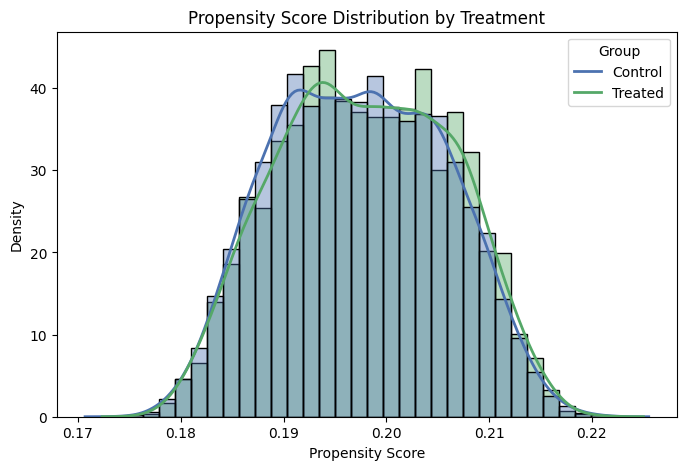

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 基本設定
plt.figure(figsize=(8,5))

# ヒストグラム＋KDE
sns.histplot(df, x='propensity_score', hue='treatment',
             bins=30, stat='density', common_norm=False,
             palette=['#4C72B0','#55A868'], alpha=0.4)

sns.kdeplot(df.loc[df.treatment==0, 'propensity_score'],
            color='#4C72B0', label='Control KDE', lw=2)
sns.kdeplot(df.loc[df.treatment==1, 'propensity_score'],
            color='#55A868', label='Treated KDE', lw=2)

plt.title('Propensity Score Distribution by Treatment')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend(title='Group', labels=['Control','Treated'])
plt.show()

1. 画像の概要

この図は，処置群（Treated）と対照群（Control）の傾向スコア分布を，ヒストグラム＋密度（KDE）プロットで重ね合わせたものです。
横軸は傾向スコア（約0.17～0.22），縦軸は密度を示しています。

2. 分布の評価
- 両群ともにほぼ同じ狭い範囲（0.17～0.22）に集中しており，分布形状もほぼ重なっている
- オーバーラップ（共通支持域）は十分確保されており，極端な高／低スコア領域の欠損は見られない
- ポジティビティ（すべてのスコア領域で両群が存在）の前提はおおむね満たされている
これらから，大きなバイアス要因となる「スコアの非重複」は見られません。

3. 注意点と改善策
- 狭い分布幅
分散が小さく（0.17～0.22），モデルが群間の差異をほとんど識別していない可能性があります。
→ 変数選択や非線形項、交互作用項の追加で，モデルの識別力を再検討しましょう。
- 重みの偏り
スコアの幅が狭いと，IPW（逆確率重み付け）を使った際，ほぼ一定の重みとなりやすいです。
→ マッチングや層別化でも，十分なサンプル数が得られるか事前にシミュレーションを行ってください。
- バランスチェック
傾向スコア自体ではなく，各共変量のSMD（標準化平均差）をマッチ前後で確認し，実際にバランスが改善されているかを精査しましょう。



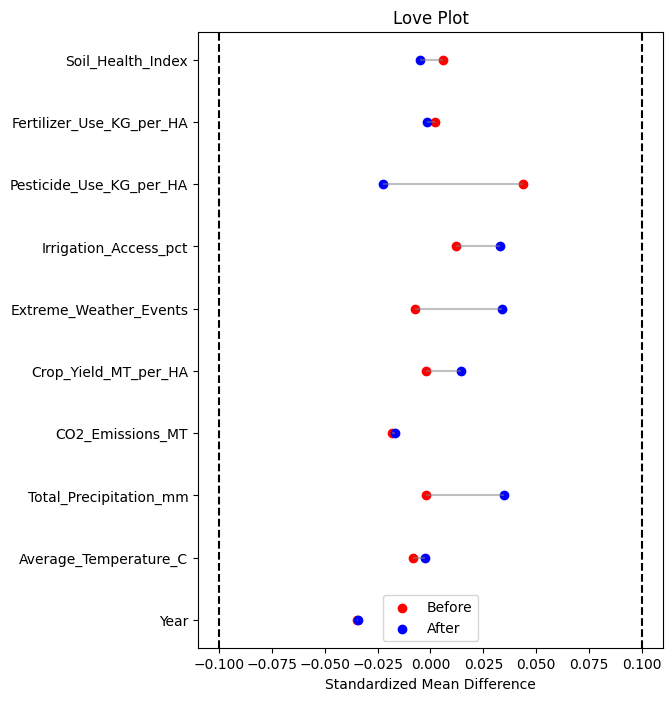

In [ ]:
# balance_df に 'variable', 'SMD_before', 'SMD_after' がある前提
vars_ = balance_df['variable']
before = balance_df['SMD_before']
after  = balance_df['SMD_after']

plt.figure(figsize=(6,8))
plt.hlines(y=vars_, xmin=before, xmax=after, color='gray', alpha=0.5)
plt.scatter(before, vars_, label='Before', color='red')
plt.scatter(after, vars_, label='After', color='blue')
plt.axvline(0.1, color='black', linestyle='--')
plt.axvline(-0.1, color='black', linestyle='--')
plt.legend()
plt.xlabel('Standardized Mean Difference')
plt.title('Love Plot')
plt.show()

図表タイトル：「図X 共変量バランスの比較（Love Plot）」

「DR推定を実施するにあたり、傾向スコアによる重み付け後に共変量のバランスを確認した。以下のLove Plotに示すように、全ての共変量で標準化差が0.1未満となり、バランスが十分に改善されたことが分かる。」


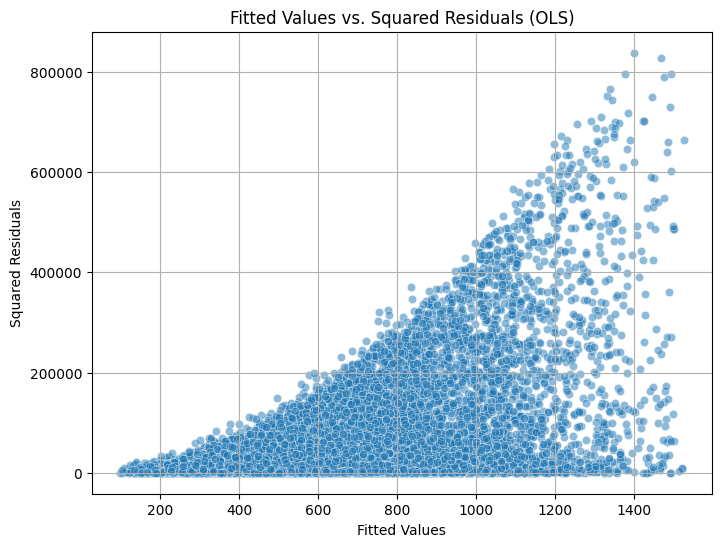

### IPW-ATE の計算

In [ ]:
# IPW-ATE 用の重み定義: w_i = (D_i / e_i) + ((1 - D_i) / (1 - e_i))
df['weight_ate'] = (df['treatment'] / df['propensity_score']) + \
                   ((1 - df['treatment']) / (1 - df['propensity_score']))

# IPW 推定 ATE の計算
outcome = 'Economic_Impact_Million_USD'
ATE_ipw = np.average(df[outcome], weights=df['weight_ate'])

print(f'IPW 推定 ATE: {ATE_ipw:.3f} 百万USD')

IPW 推定 ATE: 670.110 百万USD


### IPW-ATE のブートストラップ信頼区間

In [ ]:
n_iter_ate = 1000
ates_ipw = []

for _ in range(n_iter_ate):
    samp = df.sample(frac=1, replace=True)
    # Recalculate weights for the bootstrapped sample
    samp['weight_ate'] = (samp['treatment'] / samp['propensity_score']) + \
                         ((1 - samp['treatment']) / (1 - samp['propensity_score']))
    ates_ipw.append(np.average(samp[outcome], weights=samp['weight_ate']))

ci_lower_ate, ci_upper_ate = np.percentile(ates_ipw, [2.5, 97.5])
se_ate = np.std(ates_ipw)

print(f'IPW-ATE 標準誤差 (SE): {se_ate:.3f}')
print(f'IPW-ATE 95% CI: [{ci_lower_ate:.3f}, {ci_upper_ate:.3f}] 百万USD')

IPW-ATE 標準誤差 (SE): 4.935
IPW-ATE 95% CI: [660.490, 679.601] 百万USD


In [ ]:
pip install graphviz

In [ ]:
# 事前準備: pip install graphviz
from graphviz import Digraph

# DAGの定義
dot = Digraph(
    comment='Simple Causal DAG',
    format='png'
)
# ノードの追加
dot.node('X', 'Treatment (X)')
dot.node('Y', 'Outcome (Y)')
dot.node('Z', 'Confounder (Z)')

# エッジ（有向辺）の追加
dot.edge('Z', 'X')  # Z → X
dot.edge('Z', 'Y')  # Z → Y
dot.edge('X', 'Y')  # X → Y

# ファイルに出力＆表示
dot.render('simple_dag', view=True)

'simple_dag.png'

In [ ]:
# 例: Confounder Z1, Z2 を追加
dot = Digraph()
dot.node('X','Treatment')
dot.node('Y','Outcome')
for z in ['Z1','Z2']:
    dot.node(z, f'Confounder {z}')
    dot.edge(z,'X')
    dot.edge(z,'Y')
dot.edge('X','Y')
dot.render('dag_multiple_confounders', view=True)

'dag_multiple_confounders.pdf'